In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as func
from torch.utils.data import Dataset
import torch.nn as nn
from time import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import opendatasets as od
from pathlib import Path
from sklearn.metrics import f1_score

## Загрузка данных

In [2]:
od.download("https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset/")

Skipping, found downloaded files in "./the-simpsons-characters-dataset" (use force=True to force download)


In [3]:
train_data_dir = Path("the-simpsons-characters-dataset/simpsons_dataset")
train_paths = sorted(list(train_data_dir.rglob('*.jpg')))
labels = []
for i, path in enumerate(train_paths):
    label_str = str(path.parent.name)
    if label_str not in labels:
        labels.append(label_str)

labels = sorted(labels)
print(f"n_classes = {len(labels)}")
labels_dict = {}
for i, label in enumerate(labels):
    labels_dict[label] = i
print(labels_dict)

n_classes = 42
{'abraham_grampa_simpson': 0, 'agnes_skinner': 1, 'apu_nahasapeemapetilon': 2, 'barney_gumble': 3, 'bart_simpson': 4, 'carl_carlson': 5, 'charles_montgomery_burns': 6, 'chief_wiggum': 7, 'cletus_spuckler': 8, 'comic_book_guy': 9, 'disco_stu': 10, 'edna_krabappel': 11, 'fat_tony': 12, 'gil': 13, 'groundskeeper_willie': 14, 'homer_simpson': 15, 'kent_brockman': 16, 'krusty_the_clown': 17, 'lenny_leonard': 18, 'lionel_hutz': 19, 'lisa_simpson': 20, 'maggie_simpson': 21, 'marge_simpson': 22, 'martin_prince': 23, 'mayor_quimby': 24, 'milhouse_van_houten': 25, 'miss_hoover': 26, 'moe_szyslak': 27, 'ned_flanders': 28, 'nelson_muntz': 29, 'otto_mann': 30, 'patty_bouvier': 31, 'principal_skinner': 32, 'professor_john_frink': 33, 'rainier_wolfcastle': 34, 'ralph_wiggum': 35, 'selma_bouvier': 36, 'sideshow_bob': 37, 'sideshow_mel': 38, 'snake_jailbird': 39, 'troy_mcclure': 40, 'waylon_smithers': 41}


In [4]:
class SimpDataset(Dataset):
    def __init__(self, path_to_imgs, labels_dict, transform):
        self.path_to_imgs = path_to_imgs
        self.labels_dict = labels_dict
        self.transform = transform
        
    def __len__(self):
        return len(self.path_to_imgs)
        
    def __getitem__(self, id):
        img_path = str(self.path_to_imgs[id])
        image = Image.open(img_path)
        image = self.transform(image)
        
        if "kaggle_simpson_testset" in str(self.path_to_imgs[id]):
            label = str(self.path_to_imgs[id]).split("/")[-1]
            label = '_'.join(label.split('_')[:-1])
        else:
            label = str(self.path_to_imgs[id].parent.name)
        label_id = self.labels_dict[label]
        return image, label_id

In [5]:
img_size = 224
train_data_transform = transforms.Compose([
    transforms.Resize(img_size), transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_data_transform = transforms.Compose([
    transforms.Resize(img_size), transforms.CenterCrop(img_size),
    transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
train_data_dir = Path("the-simpsons-characters-dataset/simpsons_dataset")
test_data_dir = Path("the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset")
batch_size = 128

train_path = sorted(list(train_data_dir.rglob('*.jpg')))
test_path = sorted(list(test_data_dir.glob('*.jpg')))

train_dataset = SimpDataset(train_path, labels_dict, train_data_transform)
test_dataset = SimpDataset(test_path, labels_dict, test_data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
def tensor_to_img (tensor):
    image = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image 
    
def show_images(train_dataset):
    fig = plt.figure()
    n_x = 3
    n_y = 3
    for img_id in np.arange(9):
        rand_id = int(np.random.uniform(0, len(train_dataset)))
        image, label = train_dataset[rand_id]
        ax = fig.add_subplot(n_x, n_y, img_id + 1, xticks=[], yticks=[])
        ax.set_title(f"{list(labels_dict.keys())[list(labels_dict.values()).index(label)]}", fontsize=9)
        plt.imshow(tensor_to_img(image))

Размеры выборок:

In [8]:
print("Number of train images: ", len(train_dataset))
print("Number of test images: ", len(test_dataset))

Number of train images:  41866
Number of test images:  990


Примеры изображений из тренировочной выборки:

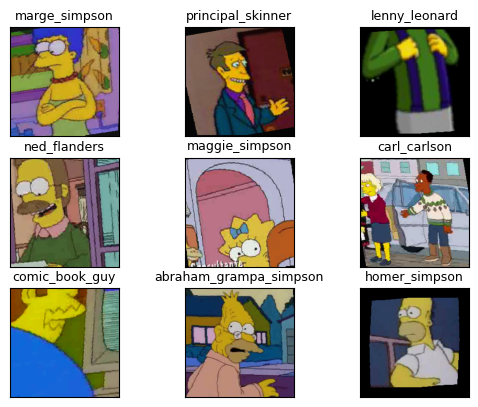

In [9]:
show_images(train_dataset)

Примеры изображений из тестовой выборки:

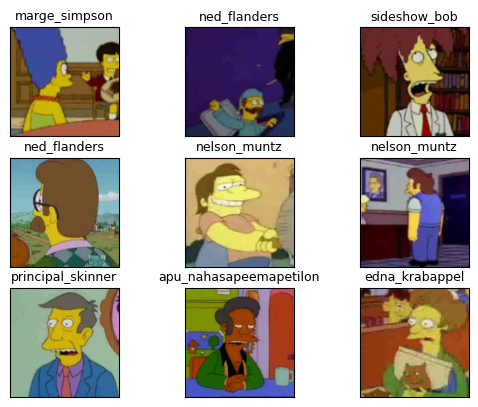

In [10]:
show_images(test_dataset)

## Построение архитектуры сети

In [11]:
class my_cnn (nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.ful_con_1 = nn.Linear(in_features=128 * 27 * 27, out_features=1024)
        self.ful_con_2 = nn.Linear(in_features=1024, out_features=42)

    def forward(self, out):
        out = self.conv_1(out)
        out = func.relu(out)
        out = func.max_pool2d(out, kernel_size=2, stride=2)
        out = self.conv_2(out)
        out = func.relu(out)
        out = func.max_pool2d(out, kernel_size=2, stride=2)
        out = self.conv_3(out)
        out = func.relu(out)
        out = func.max_pool2d(out, kernel_size=2, stride=2)
        out = out.view(-1, 128*27*27)
        out = self.ful_con_1(out)
        out = func.relu(out)
        out = self.ful_con_2(out)
        return out

In [12]:
model = my_cnn()
model

my_cnn(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ful_con_1): Linear(in_features=93312, out_features=1024, bias=True)
  (ful_con_2): Linear(in_features=1024, out_features=42, bias=True)
)

In [13]:
if not torch.cuda.is_available():
    raise RuntimeError("Cuda device is not available")
else: 
    device = torch.device("cuda:0")
    model.to(device)
    print(f'Device: {torch.cuda.get_device_name(device)}')

def get_accuracy(loader, model):
    tp = 0
    n = 0
    start_time = time()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    end_time = time()
    val_time = end_time - start_time
    accuracy = tp / n
    return accuracy, val_time

def calculate_f1(loader, model):
    labels_list = []
    preds_list = []
    start_time = time()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)            
            labels_list += labels.tolist()
            preds_list += predicted.tolist()
    end_time = time()
    val_time = end_time - start_time
    f1 = f1_score(labels_list, preds_list, average='weighted')
    return f1, val_time

def train_model(model, num_epochs, learning_rate):
        total_time = 0
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        for epoch in range(num_epochs):
            epoch_start_time = time()
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            accuracy, _ = get_accuracy(train_loader, model)
            epoch_time = time() - epoch_start_time
            total_time += epoch_time
            print(f"Epoch #{epoch+1}: train accuracy = {'{:.3f}'.format(accuracy)}, error = {'{:.3f}'.format(1-accuracy)} time = {'{:.2f}'.format(epoch_time)} sec")
        print(f"Total training time: {'{:.0f}'.format(total_time)} sec")   

Device: NVIDIA GeForce RTX 3060


## Обучение сети

In [14]:
learning_rate = 0.001
num_epochs = 20

In [15]:
train_model(model, num_epochs, learning_rate)

Epoch #1: train accuracy = 0.568, error = 0.432 time = 293.74 sec
Epoch #2: train accuracy = 0.726, error = 0.274 time = 293.22 sec
Epoch #3: train accuracy = 0.794, error = 0.206 time = 293.35 sec
Epoch #4: train accuracy = 0.848, error = 0.152 time = 291.73 sec
Epoch #5: train accuracy = 0.883, error = 0.117 time = 291.91 sec
Epoch #6: train accuracy = 0.896, error = 0.104 time = 291.96 sec
Epoch #7: train accuracy = 0.911, error = 0.089 time = 291.98 sec
Epoch #8: train accuracy = 0.924, error = 0.076 time = 292.00 sec
Epoch #9: train accuracy = 0.940, error = 0.060 time = 291.98 sec
Epoch #10: train accuracy = 0.948, error = 0.052 time = 291.94 sec
Epoch #11: train accuracy = 0.942, error = 0.058 time = 292.17 sec
Epoch #12: train accuracy = 0.956, error = 0.044 time = 292.59 sec
Epoch #13: train accuracy = 0.955, error = 0.045 time = 293.65 sec
Epoch #14: train accuracy = 0.964, error = 0.036 time = 293.60 sec
Epoch #15: train accuracy = 0.962, error = 0.038 time = 293.48 sec
Epoc

In [18]:
accuracy, test_time = get_accuracy(test_loader, model)
print(f"Test accuracy: {'{:.3f}'.format(accuracy)}, error = {'{:.3f}'.format(1-accuracy)}, accuracy computing time = {'{:.2f}'.format(test_time)} sec.")

f1, test_time = calculate_f1(test_loader, model)
print(f"Test F1-score('weighted'): {'{:.3f}'.format(f1)}, F1-score computing time = {'{:.2f}'.format(test_time)} sec.")

Test accuracy: 0.987, error = 0.013, accuracy computing time = 1.09 sec.
Test F1-score('weighted'): 0.987, F1-score computing time = 1.41 sec.
